In [18]:
from ultralytics import SAM

# Load a model
model = SAM("../sam_b.pt")

# Display model information (optional)
model.info()


Model summary: 173 layers, 93,735,472 parameters, 93,735,472 gradients


(173, 93735472, 93735472, 0.0)

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import ffmpeg
import shutil
import json
from scipy.ndimage import convolve
import csv


def extract_frames(video_path, output_folder, interval):
    os.makedirs(output_folder, exist_ok=True)
    ffmpeg.input(video_path, ss=0).output(
        f"{output_folder}frame_%03d.png", vf=f"fps=1/{interval}"
    ).run()


def create_SAM_mask(image_path, point):
    frame = cv2.imread(image_path)
    results = model(image_path, points=point, labels=[1])
    b_mask = np.zeros(frame.shape[:2], np.uint8)

    contour = results[0].masks.xy.pop()
    contour = contour.astype(np.int32)
    contour = contour.reshape(-1, 1, 2)
    _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

    return b_mask


def track_width(
    frame_folder,
    start_frame,
    anchor_point,
    output_file,
    end_frame=None,
    opening_kernel=(3, 3),
    debug=True,
    reverse_order=True,
):
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_file)
    if output_dir != '' and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    frames = sorted(
        [
            os.path.join(frame_folder, f)
            for f in os.listdir(frame_folder)
            if f.endswith((".png", ".jpg"))
        ]
    )

    start_frame = max(0, start_frame)
    end_frame = min(len(frames), end_frame if end_frame is not None else len(frames))
    print(f"Analyzing frames {start_frame} to {end_frame-1}")
    print(f"Total frames used: {end_frame - start_frame}")

    frames = frames[start_frame:end_frame]

    plt.figure(figsize=(12, 10))
    results = []
    if reverse_order:
        print('we are reversing the order')
        frames = reversed(frames)
    for i, frame_path in enumerate(frames):
        if reverse_order:
            frame_idx = len(frames) - (i - 1)
        else:
            frame_idx = i
        frame = cv2.imread(frame_path)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        b_mask = create_SAM_mask(frame_path, anchor_point)
        kernel = np.ones(opening_kernel, np.uint8)
        cleaned_b_mask = cv2.morphologyEx(b_mask, cv2.MORPH_OPEN, kernel, iterations=5)
        # import pdb; pdb.set_trace()
        # row = cleaned_b_mask[anchor_point[1]]  # extract the row at y=150
        column = cleaned_b_mask[:, anchor_point[0]]# > 0)[0]

        # Get indices where the value is white (nonzero)
        white_y_coords = np.where(column > 0)[0]

        assert len(white_y_coords) > 0
        bottom_most_y = np.min(white_y_coords)
        top_most_y = np.max(white_y_coords)
        width = top_most_y - bottom_most_y
        print(f"Frame {frame_idx}: Width = {width} bottom_most_y = {bottom_most_y} top_most_y = {top_most_y}")
        results.append([frame_idx, width])

        if debug or frame_idx % 5 == 0:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))

            axes[0, 0].imshow(frame_rgb)
            axes[0, 0].set_title("Frame")
            axes[0, 0].axis("off")
            axes[0, 1].imshow(frame_rgb)
            axes[0, 1].set_title("Frame with Point Selected")
            size = 10  # Size of the "X"
            thickness = 2  # Thickness of the lines
            axes[0, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [anchor_point[1] - size, anchor_point[1] + size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [anchor_point[1] + size, anchor_point[1] - size],
                color="green",
                linewidth=thickness,
            )
            axes[0, 1].axis("off")
            axes[0, 2].imshow(b_mask, cmap="gray")
            axes[0, 2].set_title("Binary Mask")
            axes[0, 2].axis("off")
            axes[1, 0].imshow(cleaned_b_mask, cmap="gray")
            axes[1, 0].set_title("Cleaned Binary Mask")
            axes[1, 0].axis("off")
            axes[1, 1].imshow(cleaned_b_mask)
            axes[1, 1].set_title(f"Top & Bottom Points (width: {width})")
            size = 10  # Size of the "X"
            thickness = 2  # Thickness of the lines
            axes[1, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [top_most_y - size, top_most_y + size],
                color="blue",
                linewidth=thickness,
            )
            axes[1, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [top_most_y + size, top_most_y - size],
                color="blue",
                linewidth=thickness,
            )
            axes[1, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [bottom_most_y - size, bottom_most_y + size],
                color="red",
                linewidth=thickness,
            )
            axes[1, 1].plot(
                [anchor_point[0] - size, anchor_point[0] + size],
                [bottom_most_y + size, bottom_most_y - size],
                color="red",
                linewidth=thickness,
            )
            axes[1, 1].axis("off")
            plt.tight_layout()
            plt.show()
        break
    
    # 💾 Write to CSV
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['frame_idx', 'width'])
        writer.writerows(results)

    print(f"Widths saved to {output_file}")


# Start with the 20C experiment tracking the WT 

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Analyzing frames 3 to 141
Total frames used: 139

image 1/1 /Users/yitongtseo/Documents/GitHub/cellulose_origami/strain_rate_experiments/tracking_frames/frame_142.png: 1024x1024 1 0, 8639.7ms
Speed: 52.6ms preprocess, 8639.7ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 140: Width = 30 bottom_most_y = 335 top_most_y = 365


<Figure size 1200x1000 with 0 Axes>

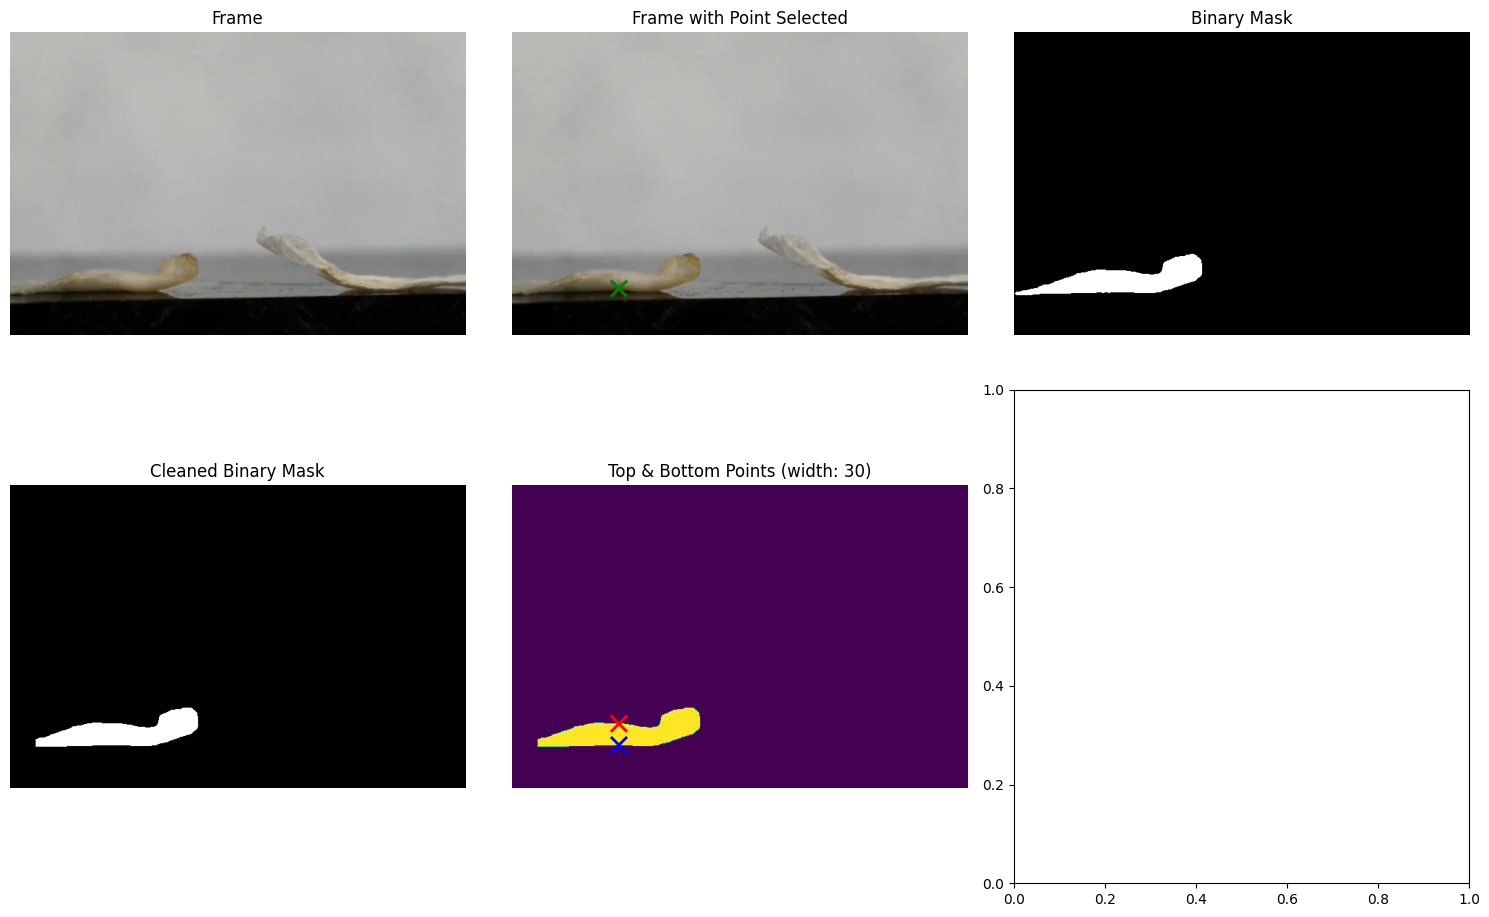

FileNotFoundError: [Errno 2] No such file or directory: 'strain_rate_experiments/drying_take_1_100x_tracked.csv'

In [ ]:
# Set paths
output_name = 'WT_strain_rate_20C.csv'
video_name = f"drying_take_1_100x" # without the .mov
video_path = f"{video_name}.mov"
temp_folder = "tracking_frames/"
start_frame = 3
end_frame = None
frame_interval=0.6
point = (150, 360)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_width(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=output_name,
    anchor_point=point,
)


for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Analyzing frames 3 to 141
Total frames used: 139



[out#0/image2 @ 0x7fcbd0604400] video:13551KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: unknown
frame=  142 fps=0.0 q=-0.0 Lsize=N/A time=00:01:25.20 bitrate=N/A speed= 105x    


image 1/1 /Users/yitongtseo/Documents/GitHub/cellulose_origami/strain_rate_experiments/tracking_frames/frame_142.png: 1024x1024 1 0, 7836.6ms
Speed: 36.0ms preprocess, 7836.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 140: Width = 22 bottom_most_y = 344 top_most_y = 366


<Figure size 1200x1000 with 0 Axes>

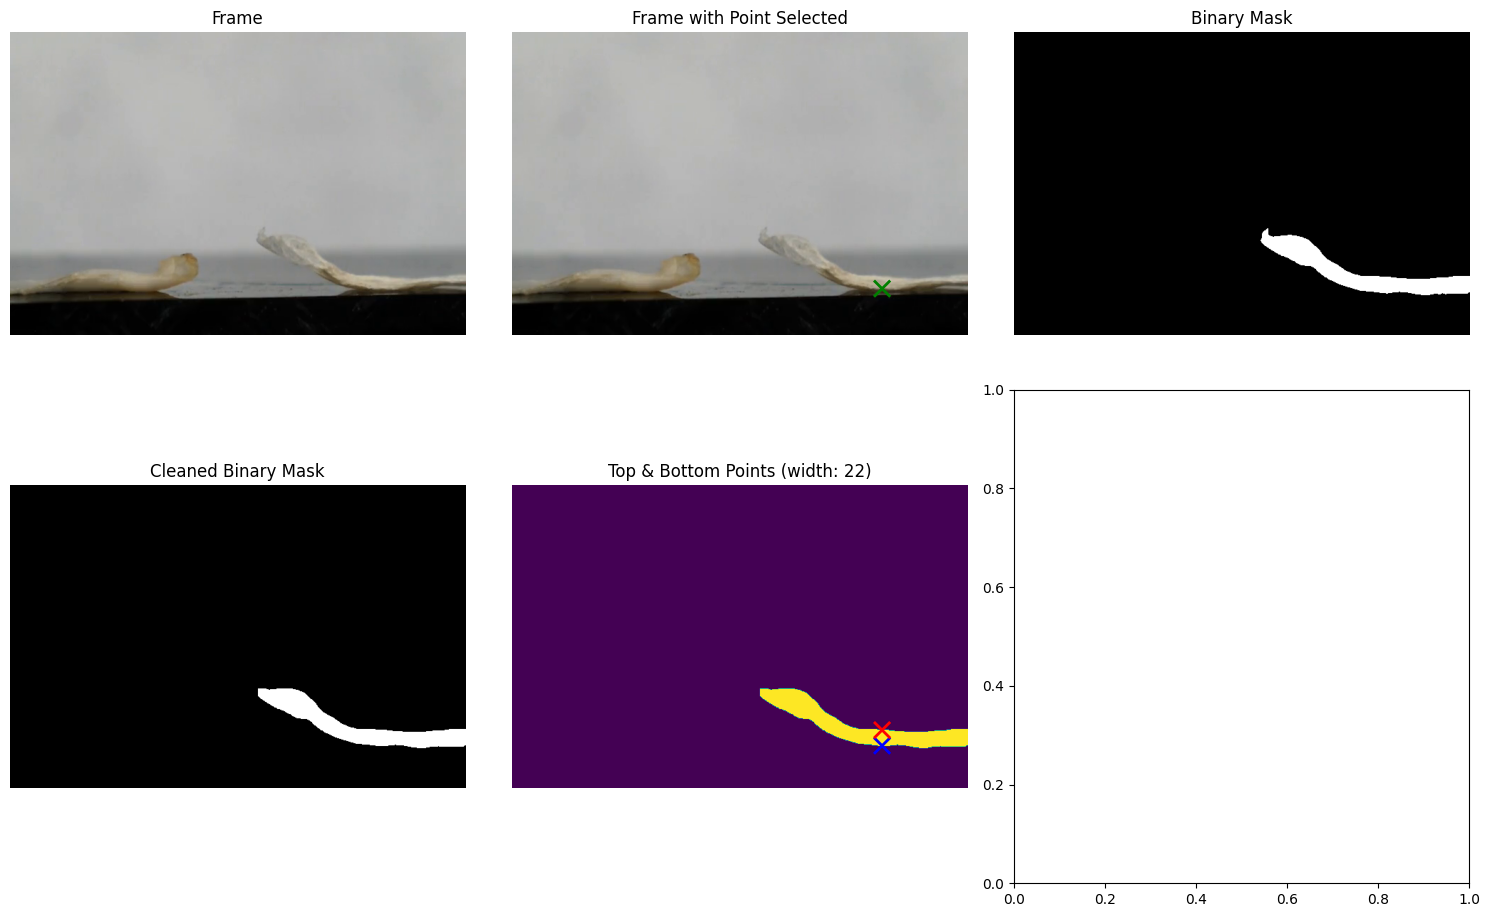

Widths saved to BslA_strain_rate_120C.csv


In [ ]:
# Set paths
output_name = 'BslA_strain_rate_20C.csv'
video_name = f"drying_take_1_100x" # without the .mov
video_path = f"{video_name}.mov"
temp_folder = "tracking_frames/"
start_frame = 3
end_frame = None
frame_interval=0.6
point = (520, 360)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_width(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=output_name,
    anchor_point=point,
)


for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)

# Now calculate the drying rate for 120C

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Analyzing frames 3 to 35
Total frames used: 33



[out#0/image2 @ 0x7f7cf4d05980] video:3032KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: unknown
frame=   36 fps=0.0 q=-0.0 Lsize=N/A time=00:00:21.60 bitrate=N/A speed=  93x    


image 1/1 /Users/yitongtseo/Documents/GitHub/cellulose_origami/strain_rate_experiments/tracking_frames/frame_036.png: 1024x1024 1 0, 8771.0ms
Speed: 34.1ms preprocess, 8771.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 34: Width = 27 bottom_most_y = 345 top_most_y = 372


<Figure size 1200x1000 with 0 Axes>

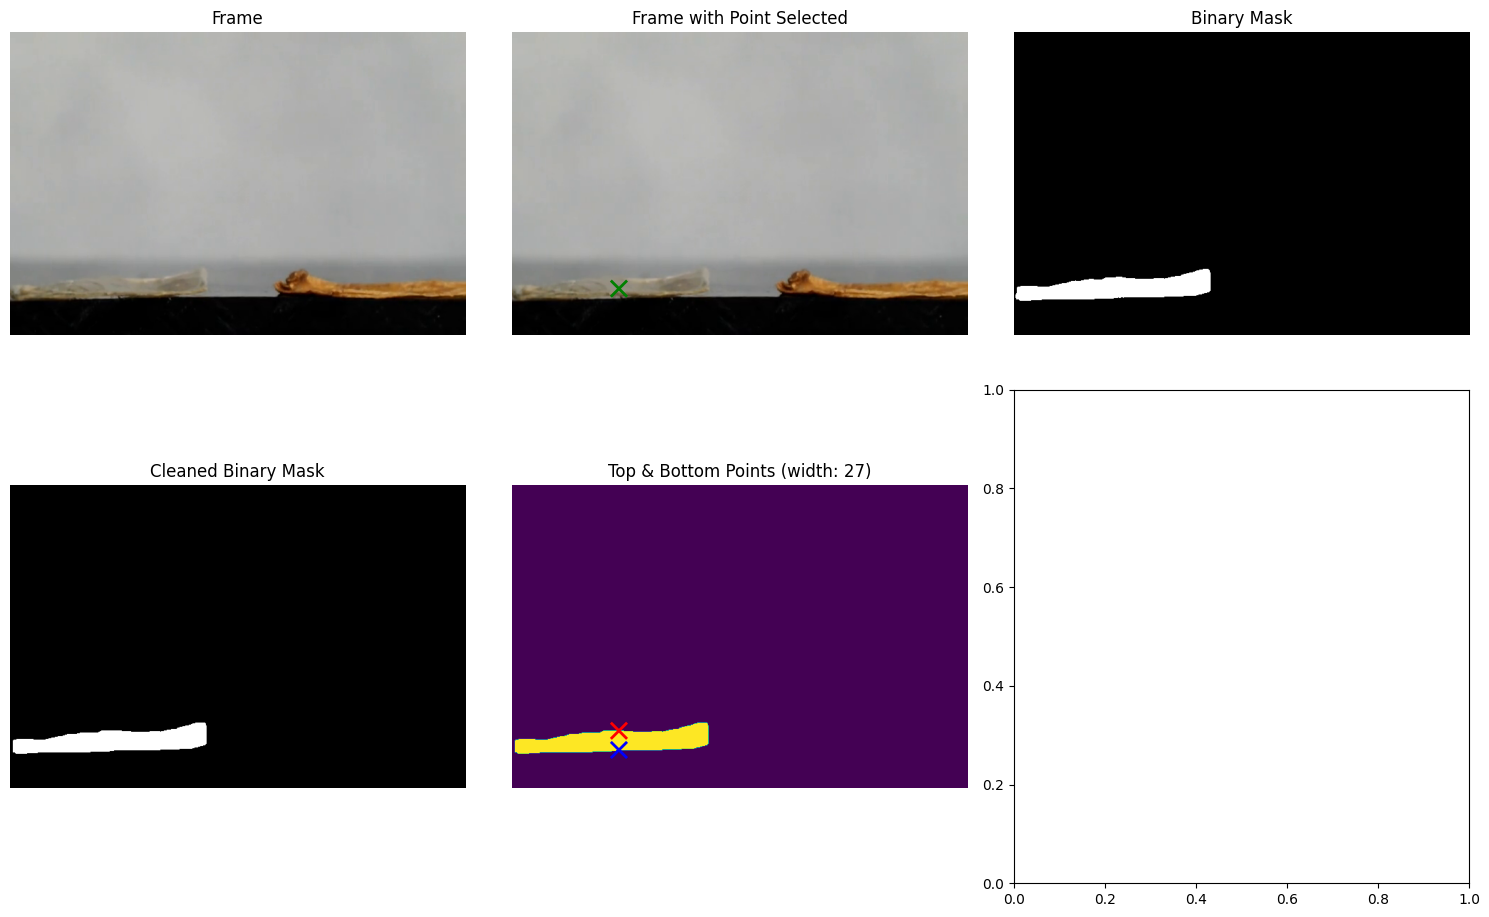

Widths saved to WT_strain_rate_120C.csv


In [ ]:
# Set paths
output_name = 'BslA_strain_rate_120C.csv'
video_name = f"drying_take_2_100x" # without the .mov
video_path = f"{video_name}.mov"
temp_folder = "tracking_frames/"
start_frame = 0
end_frame = None
frame_interval=0.6
point = (150, 360)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_width(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=output_name,
    anchor_point=point,
    reverse_order=False,
)


for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --ena

Analyzing frames 0 to 35
Total frames used: 36



[out#0/image2 @ 0x7f8da602ba40] video:3032KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: unknown
frame=   36 fps=0.0 q=-0.0 Lsize=N/A time=00:00:21.60 bitrate=N/A speed= 113x    


image 1/1 /Users/yitongtseo/Documents/GitHub/cellulose_origami/strain_rate_experiments/tracking_frames/frame_001.png: 1024x1024 1 0, 8133.6ms
Speed: 50.7ms preprocess, 8133.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)
Frame 0: Width = 67 bottom_most_y = 309 top_most_y = 376


<Figure size 1200x1000 with 0 Axes>

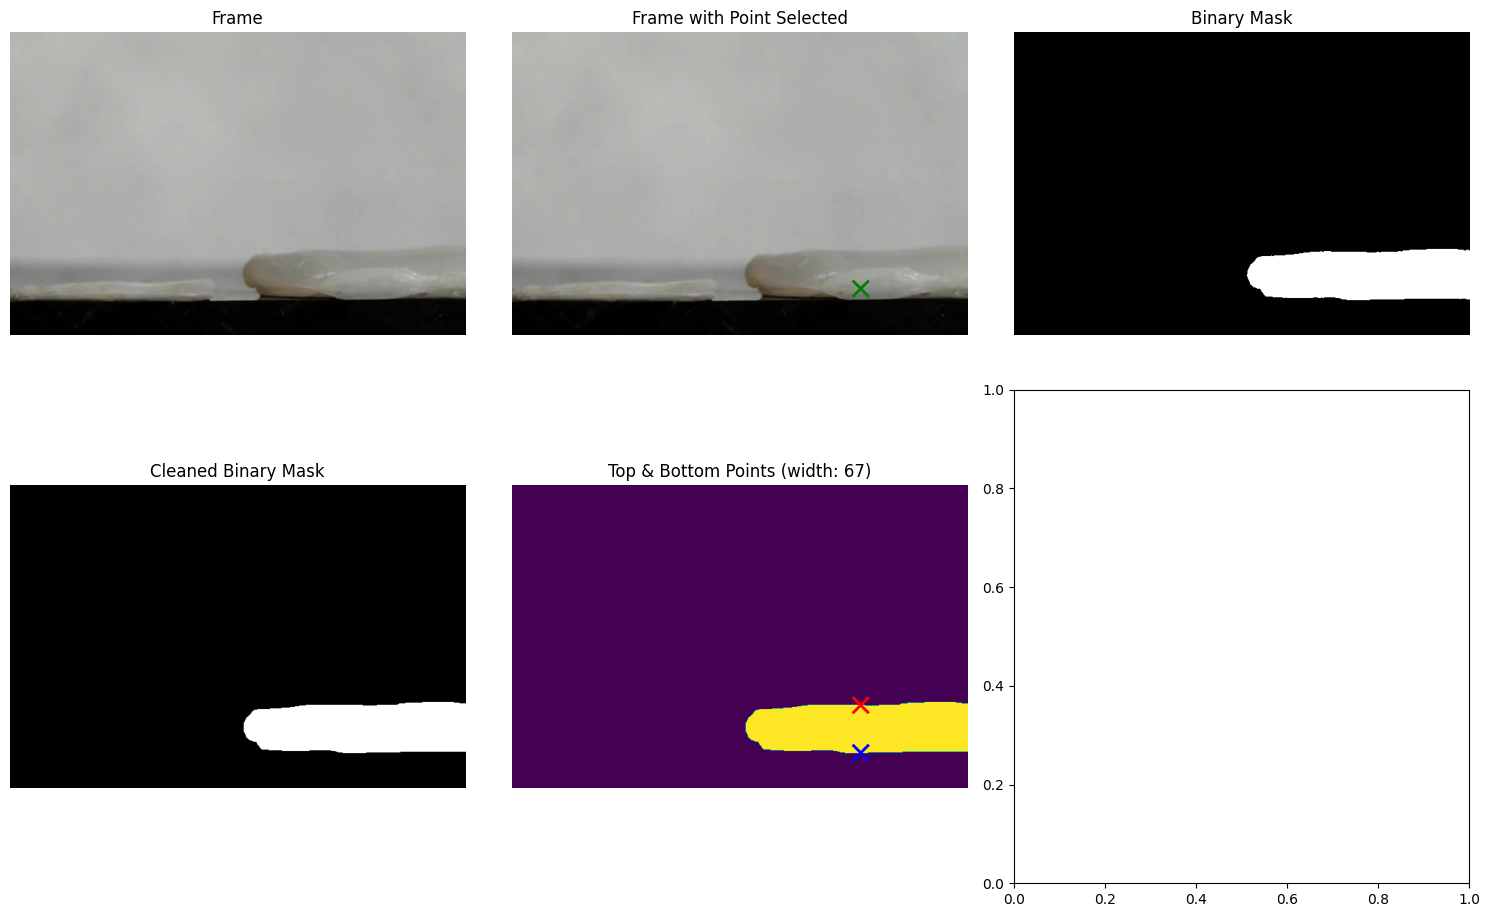

Widths saved to BslA_strain_rate_120C.csv


In [32]:
# Set paths
output_name = 'BslA_strain_rate_120C.csv'
video_name = f"drying_take_2_100x" # without the .mov
video_path = f"{video_name}.mov"
temp_folder = "tracking_frames/"
start_frame = 0
end_frame = None
frame_interval=0.6
point = (490, 360)

extract_frames(video_path, temp_folder, interval=frame_interval)

track_width(
    frame_folder=temp_folder,
    start_frame=start_frame,
    end_frame=end_frame,
    output_file=output_name,
    anchor_point=point,
    reverse_order=False,
)


for filename in os.listdir(temp_folder):
    file_path = os.path.join(temp_folder, filename)
    if os.path.isdir(file_path):
        shutil.rmtree(file_path)
    else:
        os.remove(file_path)